In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [2]:
hamiltorch.set_random_seed(123)
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

* Defining model

In [3]:
class Net(nn.Module):
    def __init__(self, layer_sizes, loss = 'multi_class', bias=True):
        super(Net, self).__init__()
        self.layer_sizes = layer_sizes
        self.layer_list = []
        self.loss = loss
        self.bias = bias
        self.l1 = nn.Linear(layer_sizes[0], layer_sizes[1],bias = self.bias)
#         self.l2 = nn.Linear(layer_sizes[1], layer_sizes[2],bias = self.bias)

    def forward(self, x):
        x = self.l1(x)
#         x = torch.softmax(x)
#         x = self.l2(x)
        return x
#         output = self.layer_list[-1](x)
#         if self.loss is 'binary_class' or 'regression':
#             return output
#         if self.loss is 'multi_class':
#         return F.log_softmax(x, dim=1)
layer_sizes = [4,3]
model = Net(layer_sizes)
print(model)

Net(
  (l1): Linear(in_features=4, out_features=3, bias=True)
)


In [4]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
         [-0.4260,  0.3665, -0.3634, -0.3975],
         [-0.3159,  0.2264, -0.1847,  0.1871]], requires_grad=True),
 Parameter containing:
 tensor([-0.4244, -0.3034, -0.1836], requires_grad=True)]

In [290]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 140#10#50
N_val = 140
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)

trainx= x_train
trainy=y_train#nn.functional.one_hot(y_train%3, num_classes=3)

* Training model

In [7]:
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()

In [8]:
for epoch in range(4000):
    #x_, y_ = sample(data, count= 64)
    #x_,y_= data.values[:,0].reshape(-1,1), data.values[:,1]
    
    #trainx = Variable(torch.Tensor(x_train).float(), requires_grad= True)
    #trainy = Variable(torch.reshape(torch.Tensor(y_).float(), (-1,1)))
    optimizer.zero_grad()
    y_pred= model(trainx)
    
    l = loss(y_pred, trainy)
    #losses.append(l.item())
    if epoch%1000==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    
    l.backward()
    optimizer.step()

epoch:  0  loss:  1.3596820831298828
epoch:  1000  loss:  0.37445205450057983
epoch:  2000  loss:  0.24677099287509918
epoch:  3000  loss:  0.17584633827209473


In [9]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.5151,  1.2212, -1.7292, -1.2839],
         [ 0.9382, -0.8014, -0.1096, -1.1717],
         [ 0.9362, -1.3702,  2.0526,  2.5280]], requires_grad=True),
 Parameter containing:
 tensor([-0.7680,  1.5440, -2.1664], requires_grad=True)]

* Trial 1

In [73]:
params_init = hamiltorch.util.flatten(model).to(device).clone()

In [14]:
def define_model_log_prob(model, model_loss, x, y, params_flattened_list, params_shape_list, tau_list, tau_out, predict=False):
    fmodel = util.make_functional(model)
    dist_list = []
    for tau in tau_list:
        dist_list.append(torch.distributions.Normal(torch.zeros_like(tau_list[0]), tau**-0.5))

    def log_prob_func(params):
        # model.zero_grad()
        # params is flat
        # Below we update the network weights to be params
        params_unflattened = util.unflatten(model, params)

        i_prev = 0
        l_prior = params#torch.zeros_like( params[0], requires_grad=True) # Set l2_reg to be on the same device as params
        for weights, index, shape, dist in zip(model.parameters(), params_flattened_list, params_shape_list, dist_list):
            # weights.data = params[i_prev:index+i_prev].reshape(shape)
            w = params[i_prev:index+i_prev]
            l_prior = dist.log_prob(w).sum() + l_prior
            i_prev += index

        # Sample prior if no data
        if x is None:
            # print('hi')
            return l_prior#/y.shape[0]


        output = fmodel(x,params=params_unflattened)

        if model_loss is 'binary_class':
            crit = nn.BCEWithLogitsLoss(reduction='sum')
            ll = - tau_out *(crit(output, y))
        elif model_loss is 'multi_class_linear_output':
    #         crit = nn.MSELoss(reduction='mean')
            crit = nn.CrossEntropyLoss(reduction='sum')
    #         crit = nn.BCEWithLogitsLoss(reduction='sum')
            ll = - tau_out *(crit(output, y.long().view(-1)))
            # ll = - tau_out *(torch.nn.functional.nll_loss(output, y.long().view(-1)))
        elif model_loss is 'multi_class_log_softmax_output':
            ll = - tau_out *(torch.nn.functional.nll_loss(output, y.long().view(-1)))

        elif model_loss is 'regression':
            # crit = nn.MSELoss(reduction='sum')
            ll = - 0.5 * tau_out * ((output - y) ** 2).sum(0)#sum(0)

        elif callable(model_loss):
            # Assume defined custom log-likelihood.
            ll = - model_loss(output, y).sum(0)
        else:
            raise NotImplementedError()
        if predict:
            return ll + l_prior, output
        else:
            return ll + l_prior

    return log_prob_func

In [255]:
import torch
import torch.nn as nn
from enum import Enum

from numpy import pi
from hamiltorch import util


class Sampler(Enum):
    HMC = 1
    RMHMC = 2
    HMC_NUTS = 3
    # IMPORTANCE = 3
    # MH = 4


class Integrator(Enum):
    EXPLICIT = 1
    IMPLICIT = 2
    S3       = 3


class Metric(Enum):
    HESSIAN = 1
    SOFTABS = 2
    JACOBIAN_DIAG = 3

def sample_model(model, x, y, params_init, model_loss='multi_class_linear_output' ,num_samples=10, num_steps_per_sample=10, step_size=0.1, burn=0, inv_mass=None, jitter=None, normalizing_const=1., softabs_const=None, explicit_binding_const=100, fixed_point_threshold=1e-5, fixed_point_max_iterations=1000, jitter_max_tries=10, sampler=Sampler.HMC, integrator=Integrator.IMPLICIT, metric=Metric.HESSIAN, debug=False, tau_out=1.,tau_list=None):
    import hamiltorch
    params_shape_list = []
    params_flattened_list = []
    build_tau = False
    if tau_list is None:
        tau_list = []
        build_tau = True
    for weights in model.parameters():
        params_shape_list.append(weights.shape)
        params_flattened_list.append(weights.nelement())
        if build_tau:
            tau_list.append(1.)

    log_prob_func = define_model_log_prob(model, model_loss, x, y, params_flattened_list, params_shape_list, tau_list, tau_out)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return hamiltorch.sample(log_prob_func, params_init, num_samples=num_samples, num_steps_per_sample=num_steps_per_sample, step_size=step_size, burn=burn, jitter=jitter, inv_mass=inv_mass, normalizing_const=normalizing_const, softabs_const=softabs_const, explicit_binding_const=explicit_binding_const, fixed_point_threshold=fixed_point_threshold, fixed_point_max_iterations=fixed_point_max_iterations, jitter_max_tries=jitter_max_tries, sampler=sampler, integrator=integrator, metric=metric, debug=debug, desired_accept_rate=0.8)

* Sampling params using HMC

In [55]:
## Set hyperparameters for network

tau_list = []
tau = 1.#/100. # iris 1/10
for w in model.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

hamiltorch.set_random_seed(123)
params_init = hamiltorch.util.flatten(model).to(device).clone()

step_size = 0.1 # 0.5
num_samples = 300#1000
L = 20#3
tau_out = 1.

params_hmc = hamiltorch.sample_model(model, x_train[:10,:], y_train[:10], params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 300/300 | 72.40       
Acceptance Rate 0.99


In [56]:
len(params_hmc)

5981

In [77]:
params_init

tensor([-1.5151,  1.2212, -1.7292, -1.2839,  0.9382, -0.8014, -0.1096, -1.1717,
         0.9362, -1.3702,  2.0526,  2.5280, -0.7680,  1.5440, -2.1664],
       grad_fn=<CloneBackward>)

* Reporting samples

In [80]:
from collections import defaultdict
import pandas as pd
all_theta_di = defaultdict(list)
for sample in params_hmc:
    [all_theta_di['theta_{}'.format(1+ idx)].append(sample[idx].numpy()) for idx in range(len(sample))]
df_all_theta = pd.DataFrame(all_theta_di)
df_all_theta

,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,theta_9,theta_10,theta_11,theta_12,theta_13,theta_14,theta_15
0,-1.5151206,1.2212245,-1.7291895,-1.2838798,0.93815035,-0.8014387,-0.10963513,-1.1716723,0.93621886,-1.3702186,2.0525959,2.5280046,-0.7680219,1.5439752,-2.1664016
1,-0.13473429,0.31708467,-0.6759863,-0.558126,-0.29277536,-0.35336792,-0.36505488,0.07022159,-0.47768652,0.48001423,-0.23512468,-0.7304475,0.770863,0.065015435,0.79426897
2,-0.08227636,0.29863626,-0.8144813,-0.5556204,-0.3375787,-0.26155457,-0.5081047,0.14701295,-0.33574104,0.24847324,-0.09795299,-0.7240465,0.7285374,-0.06586236,0.86124265
3,-0.05459147,0.30450073,-0.9745288,-0.5743385,-0.3627625,-0.18827876,-0.645062,0.212905,-0.18108615,0.0083013475,0.068884134,-0.674196,0.6705766,-0.17756343,0.90943563
4,-0.043844227,0.3245802,-1.1440973,-0.60476816,-0.36389703,-0.13817185,-0.77031213,0.27080202,-0.02755849,-0.2241619,0.24904212,-0.5942826,0.59748966,-0.26380107,0.9332668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,-0.66038585,0.2698785,0.3551882,-1.5309932,0.8525387,-1.6586319,0.011883181,-0.840129,0.32154644,-0.14429434,0.26593325,0.7227252,-1.2397819,0.18674198,-0.8099884
5977,-0.59887314,0.43481296,0.3701826,-1.5989387,0.81993717,-1.6951573,0.037956662,-0.8864032,0.32442817,0.020353258,0.30291364,0.7214215,-1.1710827,0.10480026,-0.8224599
5978,-0.5342191,0.5979254,0.37809864,-1.6540794,0.7748345,-1.7138623,0.0559861,-0.9308381,0.33121476,0.18140239,0.3479059,0.72311294,-1.0900209,0.017314263,-0.8228624
5979,-0.46688297,0.75718176,0.37927365,-1.6954422,0.71885675,-1.7143828,0.06663349,-0.9723302,0.34047613,0.3374685,0.39920133,0.7267017,-0.9979546,-0.07319381,-0.81229156


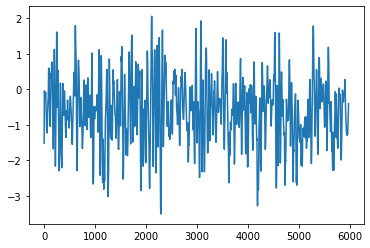

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df_all_theta['theta_1'].values)
plt.show()

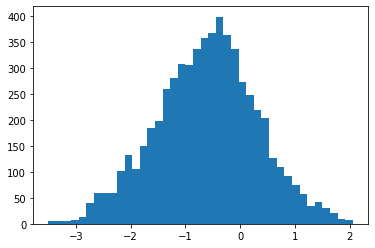

In [92]:
_ = plt.hist(df_all_theta['theta_1'].values, bins=40)

In [93]:
np.quantile(df_all_theta['theta_1'].values, 0.1)

-1.8319803476333618

In [94]:
np.quantile(df_all_theta['theta_1'].values, 0.9)

0.5331450700759888

In [99]:
np.mean(df_all_theta['theta_1'].values)

-0.6126612

### Contrasting results with statsmodel on  iris binary dataset

In [320]:
data = load_iris()
x_ = data['data']
y_ = data['target']
y_[np.where(y_>=1)]= 1

N_tr = 140#10#50
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
x_train = x_[train_index]
y_train = y_[train_index]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
trainx = torch.FloatTensor(x_train)
trainy = torch.FloatTensor(y_train)

#trainx= x_train
#trainy=y_train#nn.functional.one_hot(y_train%3, num_classes=3)

In [327]:
import statsmodels.api as sm
feats, targets= x_train, y_train

In [331]:
#Without standard scaling of data
model_stm = sm.Logit(targets, feats)#, hasconst=True)
result= model_stm.fit(disp=0)

print(result.summary())
print('Parameters: ', model_stm.params)

PerfectSeparationError: Perfect separation detected, results not available

#### Training pytorch model on binary iris dataset

In [292]:
class toynet(nn.Module):
    def __init__(self):
        super(toynet, self).__init__()
        self.fc1 = nn.Linear(4,1)
        self.sig = nn.Sigmoid()
        #torch.nn.init.xavier_normal_(self.fc1.weight)
    def forward(self, x):
        x= self.fc1(x)
        x= self.sig(x)
        return x

model2 = toynet()
model2

toynet(
  (fc1): Linear(in_features=4, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [274]:
optimizer2 = optim.Adam(model2.parameters())
loss2 = nn.BCELoss()#MSELoss()

In [296]:
import torch
from torch.utils import data as d
import time

class Dataset(d.Dataset):
    def __init__(self, list_IDs, features, labels):
        'Initialization'
        self.labels = labels
        self.features= features
        self.list_IDs = list_IDs
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = self.features[ID]#torch.load('data/' + ID + '.pt')
        y = self.labels[ID]

        return X, y

In [300]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

partition = {'train':list(range(y_train.shape[0]))}# IDs
features= {idx:record for idx, record in enumerate(trainx)}
labels = {idx:record for idx, record in enumerate(trainy)}# Labels
training_set = Dataset(partition['train'],features, labels)
training_generator = d.DataLoader(training_set, **params)

In [301]:
import time
max_epochs = 400
t1=time.time()
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer2.zero_grad()
        y_pred= model2(local_batch)    
        l = loss2(y_pred, local_labels)
        l.backward()
        optimizer2.step()
    if epoch%50==0:
            print('epoch: ', epoch, ' loss: ', l.item());
print('total exe. time:', time.time()-t1)

epoch:  0  loss:  0.6551912426948547


/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch:  50  loss:  0.6561346054077148
epoch:  100  loss:  0.7189800143241882
epoch:  150  loss:  0.6500689387321472
epoch:  200  loss:  0.6889770030975342
epoch:  250  loss:  0.6572744846343994
epoch:  300  loss:  0.6574429869651794
epoch:  350  loss:  0.7354534268379211
total exe. time: 23.790198802947998


In [310]:
## Set hyperparameters for network

tau_list = []
tau = 1.#/100. # iris 1/10
for w in model2.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)
params_init2 = hamiltorch.util.flatten(model2).to(device).clone()

step_size = 0.1 # 0.5
num_samples = 300#1000
L = 20#3
tau_out = 1.

params_hmc_2 = hamiltorch.sample_model(model2, trainx[:10,:],torch.reshape(trainy[:10], (10,1)), params_init=params_init2,
                        model_loss='binary_class', num_samples=num_samples,
                        step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 300/300 | 67.62       
Acceptance Rate 1.00


In [311]:
from collections import defaultdict
import pandas as pd
all_theta_di_2 = defaultdict(list)
for sample in params_hmc_2:
    [all_theta_di_2['theta_{}'.format(1+ idx)].append(sample[idx].numpy()) for idx in range(len(sample))]
df_all_theta_2 = pd.DataFrame(all_theta_di_2)
df_all_theta_2

,theta_1,theta_2,theta_3,theta_4,theta_5
0,-0.08414519,0.27630907,0.40848005,-0.18345207,0.34426785
1,1.3943243,0.59455216,1.04835,1.211498,0.32972705
2,1.2111136,0.63445413,0.98593813,1.165779,0.25869206
3,1.0159209,0.66505915,0.9153392,1.1098158,0.18706638
4,0.8109594,0.6858541,0.83761716,1.0445771,0.11559208
...,...,...,...,...,...
5976,1.3296005,-0.90073866,0.30641448,1.031989,-0.029517297
5977,1.246246,-0.98690265,0.4566331,1.047524,-0.02419262
5978,1.1506757,-1.0653403,0.6038103,1.0539149,-0.016757343
5979,1.0438529,-1.1350284,0.74634826,1.0509764,-0.007436623


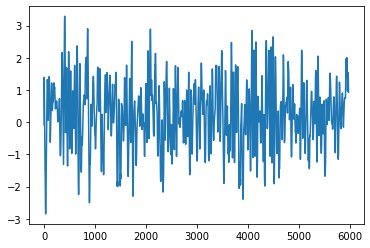

In [312]:
plt.plot(df_all_theta_2['theta_1'].values)
plt.show()

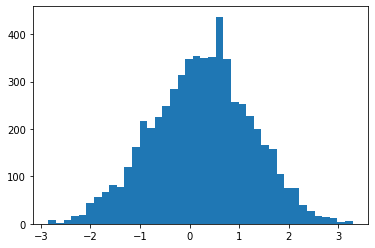

In [313]:
_ = plt.hist(df_all_theta_2['theta_1'].values, bins=40)

In [314]:
np.quantile(df_all_theta_2['theta_1'].values, 0.1)

-1.0618492364883423

In [315]:
np.quantile(df_all_theta_2['theta_1'].values, 0.9)

1.5352977514266968

In [316]:
np.mean(df_all_theta_2['theta_1'].values)

0.24560228

### Contrasting statsmodel vs. Pytorch on simulated 1 feature 1 target data

In [464]:
X = np.round(np.random.uniform(-3,3, size= 50), 3)

a, b  = 0.5, 1#np.random.normal(0, 0.1), np.random.normal(0, 0.2)#y_pred = a+ bx
error = np.random.normal(0, 0.1, size= 50)

f= lambda x: a +b*x #+ error

data = pd.DataFrame({'features': X, 'f(x)':f(X)})
data.head(5)

,features,f(x)
0,-1.750,-1.250
1,-1.206,-0.706
2,1.406,1.906
3,-0.608,-0.108
4,-1.941,-1.441


In [465]:
data['f(x)'] = data['f(x)']+ error
data['P_ij'] = data['f(x)'].apply(lambda x: np.exp(x)/(1+ np.exp(x)))
data.head(5)

,features,f(x),P_ij
0,-1.750,-1.098989,0.249929
1,-1.206,-0.659032,0.340957
2,1.406,1.792376,0.857218
3,-0.608,-0.123849,0.469077
4,-1.941,-1.332077,0.208816


In [466]:
data['targets']=data['P_ij'].apply(lambda x: np.random.binomial(1, x)) 
data.head(5)

,features,f(x),P_ij,targets
0,-1.750,-1.098989,0.249929,0
1,-1.206,-0.659032,0.340957,1
2,1.406,1.792376,0.857218,0
3,-0.608,-0.123849,0.469077,1
4,-1.941,-1.332077,0.208816,0


In [357]:
'''
X = np.round(np.random.uniform(-3,3, size= 1000), 3)

a, b  = 0.5, 1#np.random.normal(0, 0.1), np.random.normal(0, 0.2)#y_pred = a+ bx
error = np.random.normal(0, 1, size= 1000)
f= lambda x, e : np.round(a +b*x + e, 3)

data = pd.DataFrame({'features': X, 'targets':f(X, error)})
data['targets'] = data['targets'].apply(lambda x: 0 if x<= data['targets'].median() else 1)
data.head(5)
'''

,features,targets
0,3.867,0
1,3.836,0
2,2.534,1
3,0.205,1
4,2.791,1


In [472]:
x_train, y_train= data['features'].values, data['targets'].values

x_train = (x_train-x_train.mean(0))/x_train.std(0)

x_train = torch.reshape(torch.FloatTensor(x_train), (-1,1))
y_train = torch.FloatTensor(y_train)
#trainx= x_train, trainy= y_train
print('Shape of Input data', x_train.shape, y_train.shape)

Shape of Input data torch.Size([50, 1]) torch.Size([50])


* Training statsmodel

In [467]:
import statsmodels.api as sm
feats, targets= data['features'].values, data['targets'].values
feats= sm.add_constant(feats, prepend=False)

In [468]:
model_stm = sm.Logit(targets, feats, hasconst=True)
result= model_stm.fit(disp=0)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Sat, 11 Apr 2020   Pseudo R-squ.:                  0.2789
Time:                        19:33:06   Log-Likelihood:                -24.992
converged:                       True   LL-Null:                       -34.657
Covariance Type:            nonrobust   LLR p-value:                 1.099e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9821      0.273      3.591      0.000       0.446       1.518
const          0.1417      0.352      0.403      0.687      -0.548       0.831


In [469]:
summary= result.summary()
statsm_df = pd.DataFrame(summary.tables[1].data[1:], columns=summary.tables[1].data[0])
statsm_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,x1,0.9821,0.273,3.591,0.000,0.446,1.518
1,const,0.1417,0.352,0.403,0.687,-0.548,0.831


* Training pytorch

In [478]:
trainx= x_train
trainy= y_train

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

partition = {'train':list(range(trainy.shape[0]))}# IDs
features= {idx:record for idx, record in enumerate(trainx)}
labels = {idx:record for idx, record in enumerate(trainy)}# Labels
training_set = Dataset(partition['train'],features, labels)
training_generator = d.DataLoader(training_set, **params)

In [475]:
class toynet(nn.Module):
    def __init__(self):
        super(toynet, self).__init__()
        self.fc1 = nn.Linear(1,1)
        self.sig = nn.Sigmoid()
        #torch.nn.init.xavier_normal_(self.fc1.weight)
    def forward(self, x):
        x= self.fc1(x)
        x= self.sig(x)
        return x

model3 = toynet()
model3

toynet(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [476]:
list(model3.parameters())

[Parameter containing:
 tensor([[0.8059]], requires_grad=True), Parameter containing:
 tensor([0.0737], requires_grad=True)]

In [477]:
optimizer3 = optim.Adam(model3.parameters())
loss3 = nn.BCELoss()#MSELoss()

In [479]:
import time
max_epochs = 400
t1=time.time()
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer3.zero_grad()
        y_pred= model3(local_batch)    
        l = loss3(y_pred, local_labels)
        l.backward()
        optimizer3.step()
    if epoch%50==0:
        print('epoch: ', epoch, ' loss: ', l.item());
print('total exe. time:', time.time()-t1)

epoch:  0  loss:  0.5364038348197937


/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch:  50  loss:  0.5308167338371277
epoch:  100  loss:  0.5262594819068909
epoch:  150  loss:  0.5223546624183655
epoch:  200  loss:  0.5189648866653442
epoch:  250  loss:  0.5160283446311951
epoch:  300  loss:  0.5134921073913574
epoch:  350  loss:  0.5113083124160767
total exe. time: 29.897419452667236


In [480]:
## Set hyperparameters for network
tau_list = []
tau = 1.#/100. # iris 1/10
for w in model3.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)
params_init3 = hamiltorch.util.flatten(model3).to(device).clone()

step_size = 0.1 # 0.5
num_samples = 300#1000
L = 20#3
tau_out = 1.

params_hmc_3 = hamiltorch.sample_model(model3, trainx[:10,:],torch.reshape(trainy[:10], (10,1)), params_init=params_init3,
                        model_loss='binary_class', num_samples=num_samples,
                        step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 300/300 | 62.06       
Acceptance Rate 1.00


In [501]:
list(model3.parameters())

[Parameter containing:
 tensor([[1.1432]], requires_grad=True), Parameter containing:
 tensor([0.0029], requires_grad=True)]

In [489]:
len(params_hmc_3[3000:])/10

298.1

* Reporting samples With Burn-in

In [498]:
from collections import defaultdict
import pandas as pd
all_theta_di_3 = defaultdict(list)
li= list()
params_hmc_3_ = params_hmc_3[3000:]
for idx in range(298):
    li = params_hmc_3_[idx*10:idx*10+10]
    for sample in li:
        [all_theta_di_3['theta_{}'.format(1+ i)].append(sample[i].numpy()) for i in range(len(sample))]

df_all_theta_3 = pd.DataFrame(all_theta_di_3)
df_all_theta_3

,theta_1,theta_2
0,0.71206415,0.25667962
1,0.78101194,0.2870917
2,0.8458022,0.31169713
3,0.9055803,0.33032048
4,0.9595558,0.34285572
...,...,...
2975,1.513101,-1.1541808
2976,1.5028071,-1.0799879
2977,1.4778389,-0.99539304
2978,1.4384546,-0.9013066


In [500]:
list(model3.parameters())

[Parameter containing:
 tensor([[1.1432]], requires_grad=True), Parameter containing:
 tensor([0.0029], requires_grad=True)]

In [499]:
##With Burn-in

print('Theta 1 value from HMC: {}\nTheta_1 values from statsmodel :{}'.format(np.mean(df_all_theta_3['theta_1'].values), float(statsm_df['coef'][0])))
print('\n\nTheta 2 value from HMC: {}\nTheta_2 values from statsmodel :{}'.format(np.mean(df_all_theta_3['theta_2'].values), float(statsm_df['coef'][1])))

Theta 1 value from HMC: 0.44370535016059875
Theta_1 values from statsmodel :0.9821


Theta 2 value from HMC: -0.22174787521362305
Theta_2 values from statsmodel :0.1417


In [483]:
all_theta_di_3 = defaultdict(list)
li= list()
for sample in params_hmc_3:
    [all_theta_di_3['theta_{}'.format(1+ idx)].append(sample[idx].numpy()) for idx in range(len(sample))]
df_all_theta_3 = pd.DataFrame(all_theta_di_3)
df_all_theta_3

,theta_1,theta_2
0,1.1432445,0.0028991182
1,0.42826456,-2.6220398
2,0.45366088,-2.6880548
3,0.47587824,-2.7267745
4,0.49466184,-2.7377958
...,...,...
5976,1.5028071,-1.0799879
5977,1.4778389,-0.99539304
5978,1.4384546,-0.9013066
5979,1.3850986,-0.7987412


* Reporting samples Without Burn-in

In [484]:
##Without Burn-in

print('Theta 1 value from HMC: {}\nTheta_1 values from statsmodel :{}'.format(np.mean(df_all_theta_3['theta_1'].values), float(statsm_df['coef'][0])))
print('\n\nTheta 2 value from HMC: {}\nTheta_2 values from statsmodel :{}'.format(np.mean(df_all_theta_3['theta_2'].values), float(statsm_df['coef'][1])))

Theta 1 value from HMC: 0.43321073055267334
Theta_1 values from statsmodel :0.9821


Theta 2 value from HMC: -0.11669635772705078
Theta_2 values from statsmodel :0.1417


In [404]:
np.quantile(df_all_theta_3['theta_1'].values, 0.1)

-1.618972659111023

In [405]:
np.quantile(df_all_theta_3['theta_1'].values, 0.9)


0.7857491970062256

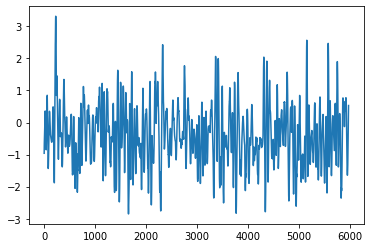

In [406]:
plt.plot(df_all_theta_3['theta_1'].values)
plt.show()

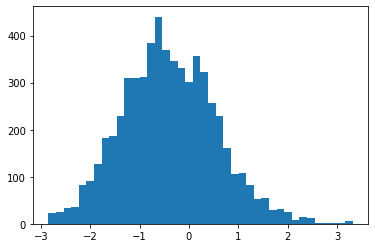

In [407]:
_ = plt.hist(df_all_theta_3['theta_1'].values, bins=40)

________________

In [ ]:
params_init2 = hamiltorch.util.flatten(model2).to(device).clone()

step_size = 0.1 # 0.5
num_samples = 300#1000
L = 20#3
tau_out = 1.

params_hmc_2= hamiltorch.sample(log_prob_func, params_init2, num_samples=300)

In [ ]:
def define_model_log_prob(model, model_loss, x, y, params_flattened_list, params_shape_list, tau_list, tau_out, predict=False):
    fmodel = util.make_functional(model)
    dist_list = []
    for tau in tau_list:
        dist_list.append(torch.distributions.Normal(torch.zeros_like(tau_list[0]), tau**-0.5))

    def log_prob_func(params):
        # model.zero_grad()
        # params is flat
        # Below we update the network weights to be params
        params_unflattened = util.unflatten(model, params)

        i_prev = 0
        l_prior = torch.zeros_like( params[0], requires_grad=True) # Set l2_reg to be on the same device as params
        for weights, index, shape, dist in zip(model.parameters(), params_flattened_list, params_shape_list, dist_list):
            # weights.data = params[i_prev:index+i_prev].reshape(shape)
            w = params[i_prev:index+i_prev]
            l_prior = dist.log_prob(w).sum() + l_prior
            i_prev += index

        # Sample prior if no data
        if x is None:
            # print('hi')
            return l_prior#/y.shape[0]


        output = fmodel(x,params=params_unflattened)

        if model_loss is 'binary_class':
            crit = nn.BCEWithLogitsLoss(reduction='sum')
            ll = - tau_out *(crit(output, y))
        elif model_loss is 'multi_class_linear_output':
    #         crit = nn.MSELoss(reduction='mean')
            crit = nn.CrossEntropyLoss(reduction='sum')
    #         crit = nn.BCEWithLogitsLoss(reduction='sum')
            ll = - tau_out *(crit(output, y.long().view(-1)))
            # ll = - tau_out *(torch.nn.functional.nll_loss(output, y.long().view(-1)))
        elif model_loss is 'multi_class_log_softmax_output':
            ll = - tau_out *(torch.nn.functional.nll_loss(output, y.long().view(-1)))

        elif model_loss is 'regression':
            # crit = nn.MSELoss(reduction='sum')
            ll = - 0.5 * tau_out * ((output - y) ** 2).sum(0)#sum(0)

        elif callable(model_loss):
            # Assume defined custom log-likelihood.
            ll = - model_loss(output, y).sum(0)
        else:
            raise NotImplementedError()
        if predict:
            return ll + l_prior, output
        else:
            return ll + l_prior

    return log_prob_func